## importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

## Importing Dataset

In [3]:
train_dir = 'dataset/train/'
test_dir = 'dataset//test/'

row, col = 224, 224
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


### PLot of number of images in training set

<AxesSubplot: >

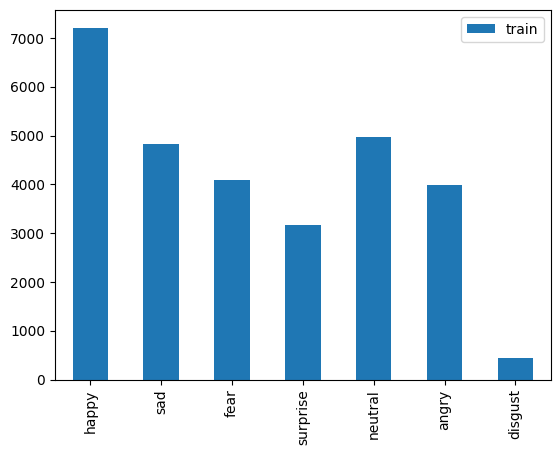

In [5]:
train_count.transpose().plot(kind='bar')

### PLot of number of images in test set

<AxesSubplot: >

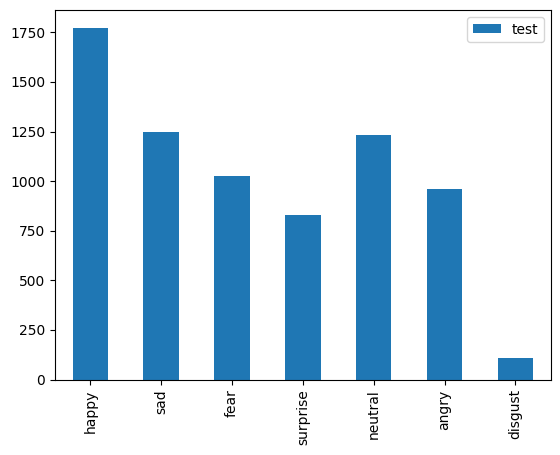

In [4]:
test_count.transpose().plot(kind='bar')

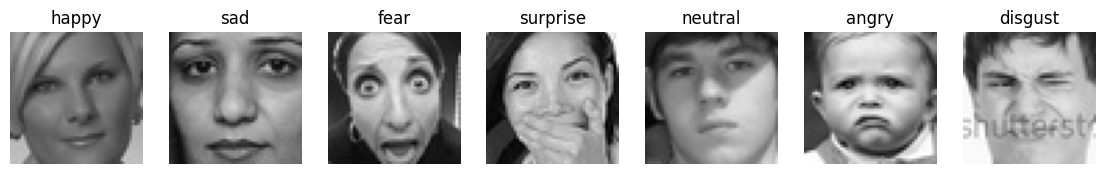

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating Training and test sets

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Defining Model

In [ ]:
def get_model(input_size, classes=7):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

### Callbacks Function

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

## Training Model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.2326 - accuracy: 0.2829
Epoch 00001: val_loss improved from inf to 5.70846, saving model to ferNet.h5
448/448 [==============================] - 84s 188ms/step - loss: 4.2326 - accuracy: 0.2829 - val_loss: 5.7085 - val_accuracy: 0.2401
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.4217 - accuracy: 0.3434
Epoch 00002: val_loss improved from 5.70846 to 3.08577, saving model to ferNet.h5
448/448 [==============================] - 39s 87ms/step - loss: 3.4217 - accuracy: 0.3434 - val_loss: 3.0858 - val_accuracy: 0.3949
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.9161 - accuracy: 0.3734
Epoch 00003: val_loss improved from 3.08577 to 2.57435, saving model to ferNet.h5
448/448 [==============================] - 39s 88ms/step - loss: 2.9161 - accuracy: 0.3734 - val_loss: 2.5743 - val_accuracy: 0.4438
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 

## Loss and Accuracy plot

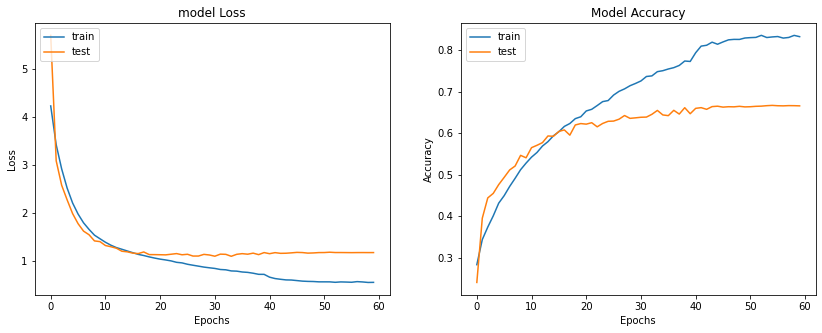

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can se seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

### Model evaluation

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 4s 38ms/step - loss: 1.1666 - accuracy: 0.6658
final train accuracy = 91.03 , validation accuracy = 66.58


In [ ]:
fernet.save_weights('fernet_bestweight.h5')

### Confusion Matrix and Classification on training set

Confusion Matrix
[[ 518   51  533 1045  726  684  438]
 [  80    9   54  103   71   68   51]
 [ 604   56  539 1048  720  674  456]
 [ 984  107  954 1847 1319 1207  797]
 [ 666   66  633 1269  896  886  549]
 [ 637   67  671 1222  901  773  559]
 [ 424   48  426  828  605  511  329]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13      3995
     disgust       0.02      0.02      0.02       436
        fear       0.14      0.13      0.14      4097
       happy       0.25      0.26      0.25      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.16      0.16      0.16      4830
    surprise       0.10      0.10      0.10      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



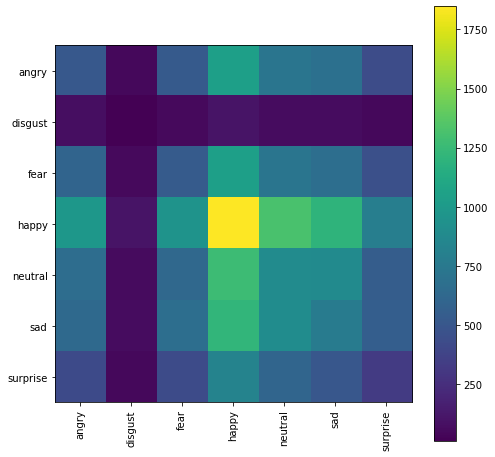

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

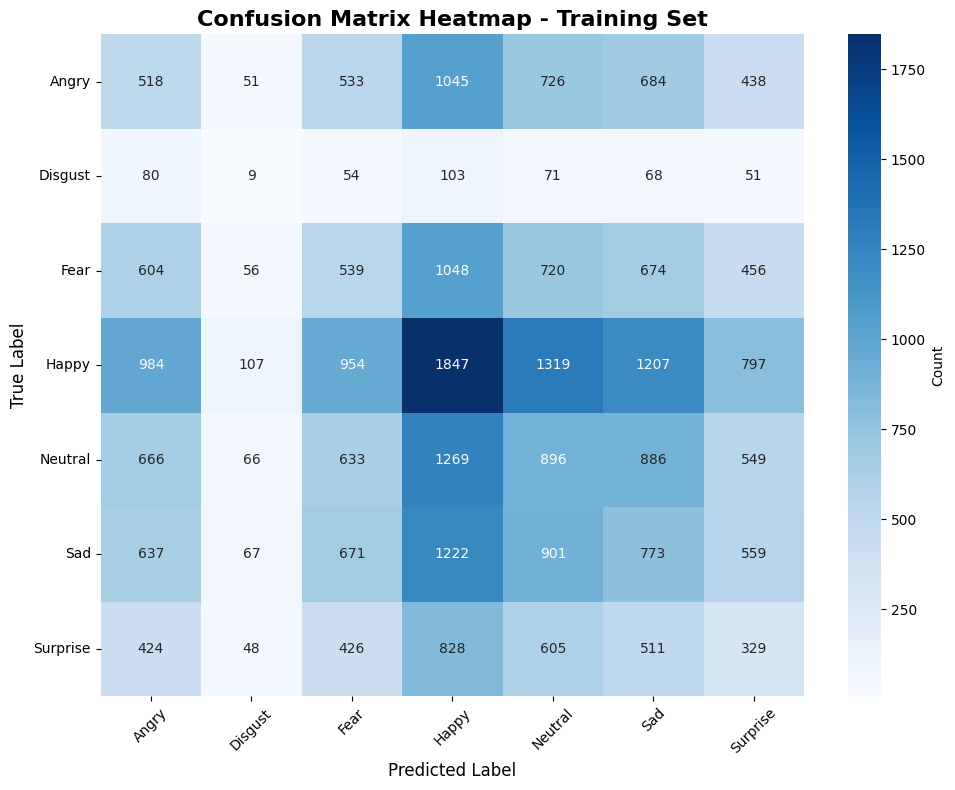

In [ ]:
import seaborn as sns

# Create enhanced heatmap using dynamic confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix Heatmap - Training Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Confusion Matrix and Classification on test set

Confusion Matrix
[[133  12  96 253 187 169 108]
 [ 13   0  12  31  22  20  13]
 [131   9 123 259 212 166 124]
 [223  18 209 450 349 324 201]
 [177  10 160 281 253 229 123]
 [194  12 146 287 235 220 153]
 [112  11 101 211 169 115 112]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.12      0.13      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.18      0.21      0.19      1233
         sad       0.18      0.18      0.18      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



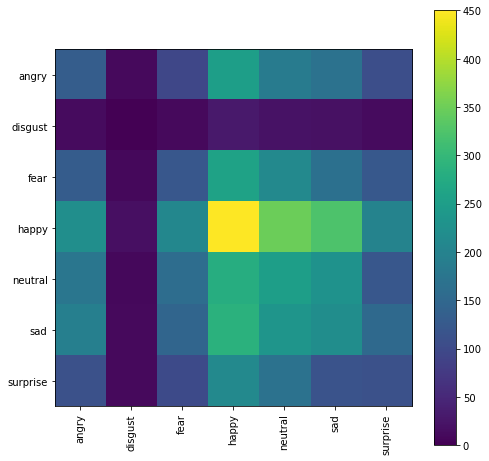

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

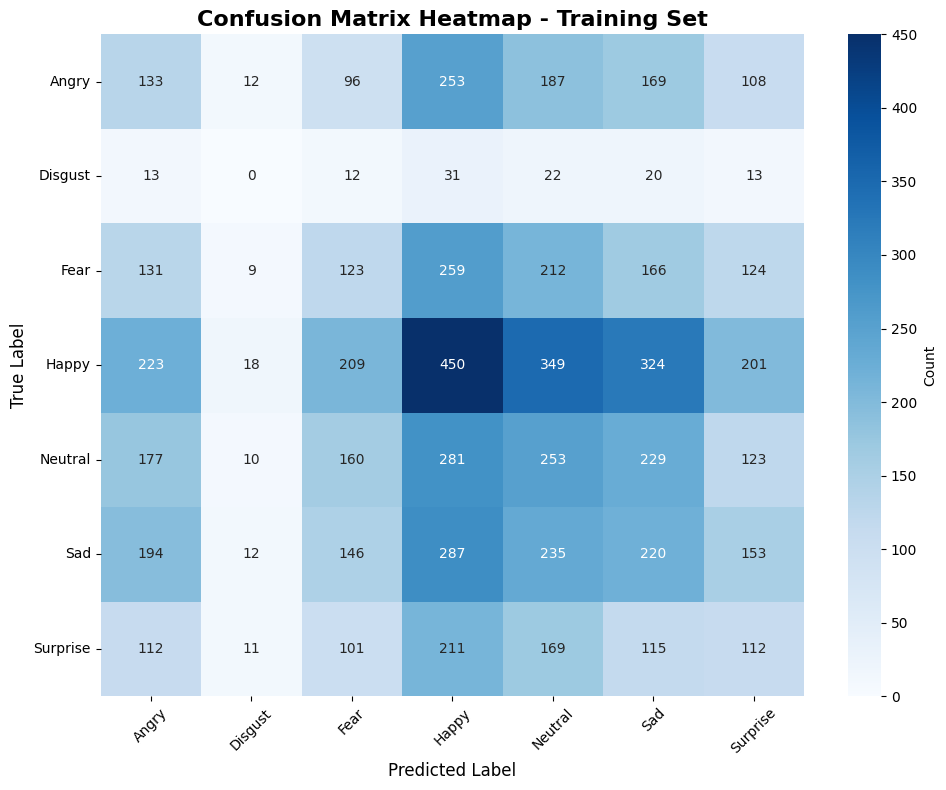

In [ ]:
import seaborn as sns

# Create enhanced heatmap using dynamic confusion matrix for test set
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, 
            annot=True, 
            fmt='d', 
            cmap='Reds',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix Heatmap - Test Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
